In [57]:
import requests
import pandas as pd
import arviz as az
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import date, timedelta
import datetime
import time
from scipy.integrate import solve_ivp
from scipy import integrate, optimize
import numpy as np

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

In [58]:
# Define the time range which starts interval_start days before the death_limit and ends interval_end days after
# The death limit will identidy the date when at least death_limit people has died in the country

interval_start = 10
interval_end = 60
death_limit = 5

short_interval_end = 20  # This is defined to identify the traffic at the beginning of the epidemic

In [59]:
# 'Czechia', and North Macedonia, 'Luxembourg' dropped for now

nordic_countries = 4 # How many countries at the beginning of the list are Nordic

european_countries = ['Sweden', 'Denmark', 'Finland', 'Norway', 
    'Germany', 'France', 'United Kingdom','Italy',
    'Spain', 'Ukraine', 'Poland', 'Romania',
    'Netherlands', 'Belgium', 'Greece', 'Portugal',
    'Hungary','Belarus', 'Austria', 'Switzerland',
    'Bulgaria', 'Serbia', 'Slovakia', 'Ireland', 
    'Croatia', 'Bosnia and Herzegovina','Lithuania', 'Moldova', 
    'Slovenia', 'Latvia', 'Estonia']

num_countries = len(european_countries)
len_interval = interval_start + interval_end 

## Let's prepare the infected and the death data

In [60]:
def load_number_infected_and_deaths():
    url = 'owid-covid-data.csv'
    data = pd.read_csv(url)
    
    data['smooth_new_cases']=data.groupby(
        'location')['new_cases'].rolling(window = 1).mean().reset_index(0,drop=True)
    
    data['smooth_new_deaths']=data.groupby(
        'location')['new_deaths'].rolling(window = 1).mean().reset_index(0,drop=True)
    
    return data

df_infected_deaths = load_number_infected_and_deaths()

In [61]:
# Find the day of the death limit

date_death_limit = []

for current_country in european_countries:
    current_date_as_string = df_infected_deaths.loc[(df_infected_deaths['total_deaths'] >= death_limit) &
                  (df_infected_deaths['location'] == current_country), 'date'].values[0]
    
    date_death_limit.append(datetime.datetime.strptime(current_date_as_string, '%Y-%m-%d'))
 
    
date_end_point = []

for current_date in date_death_limit:
    date_end_point.append(current_date + timedelta(days=interval_end))
    
    
# Find the number of total deaths per million at the end point
new_infections = []
new_deaths = []
total_deaths_per_million = []

for i in range(num_countries):
    current_country = european_countries[i]
    start_date = date_death_limit[i] - timedelta(days=interval_start) 
    end_date = date_death_limit[i] + timedelta(days=interval_end + 1) 
    
    new_infections.append(
    df_infected_deaths.loc[(df_infected_deaths['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['location'] == current_country), 'smooth_new_cases'].tolist())
        
    new_deaths.append(
    df_infected_deaths.loc[(df_infected_deaths['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['location'] == current_country), 'smooth_new_deaths'].tolist())
    
    total_deaths_per_million.append(
    df_infected_deaths.loc[(df_infected_deaths['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_infected_deaths['location'] == current_country), 'total_deaths_per_million'].tolist())


    
# Calculate the increase of new infections and deaths 
change_new_infections = []
change_new_deaths = []

for i in range(num_countries):
    current_new_infections = new_infections[i]
    current_new_deaths = new_deaths[i]

    current_change_new_infections = []
    current_change_new_deaths = []

    for j in range(len_interval):
        
        if current_new_infections[j] != 0:
            current_change_new_infections.append(current_new_infections[j+1] / current_new_infections[j])
        else:
            current_change_new_infections.append(0)

        if current_new_deaths[j] != 0:
            current_change_new_deaths.append(current_new_deaths[j+1] / current_new_deaths[j])
        else:
            current_change_new_deaths.append(0)

    change_new_infections.append(current_change_new_infections)
    change_new_deaths.append(current_change_new_deaths)
    

# Remove now the extra element

for i in range(num_countries):
    del new_infections[i][-1]
    del new_deaths[i][-1]
    del total_deaths_per_million[i][-1]
    

## Let's prepare the traffic data

In [62]:
def load_mobility_raw_onlynan():
    # url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
    url = 'Global_Mobility_Report.csv'
    data = pd.read_csv(url)
    data = data[data['sub_region_1'].isna()]
    data["date"] = pd.to_datetime(data["date"])
    
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='ffill')
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='bfill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='ffill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='bfill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='ffill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='bfill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='ffill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='bfill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='ffill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='bfill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='ffill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='bfill')

    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].apply(lambda group: group.interpolate(method='index'))
    
    datav=data.values
    tot_mobility=list()
    for j in range(datav.shape[0]):
        temp=np.nanmean([datav[j,h] for h in range(7,13,1)])
        tot_mobility.append(temp)
        
    data=data.dropna(subset=['country_region'])

    data['Total Mobility']=tot_mobility
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='ffill')
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Total Mobility'].rolling(window = 7, win_type='boxcar').mean().reset_index(0,drop=True)
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='ffill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].apply(lambda group: group.interpolate(method='index'))
    data=data.drop(columns=['sub_region_2','sub_region_1', 'iso_3166_2_code', 'census_fips_code'])
    
    return data

## Let's prepare the NPI data

In [63]:
def load_npis():
    url = 'covid-stringency-index.csv'
    data = pd.read_csv(url)
    
    data["Date"] = pd.to_datetime(data["Date"])
    return data

df_npis = load_npis()

In [64]:
npi_developments = []
npi_change_dates = []

for i in range(len(european_countries)):
    current_country = european_countries[i]
    period_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    period_end_point = date_death_limit[i] + datetime.timedelta(days=interval_end)

    current_development = df_npis.loc[(df_npis['Entity'] == current_country) &
            (df_npis['Date'] >= period_start_point) & (df_npis['Date'] < period_end_point), 'GRSI'].tolist()
    
    npi_developments.append(current_development)
    
    current_dates = []
    
    for j in range(len(current_development) -1):
        if current_development[j] != current_development[j+1]:
            current_dates.append(period_start_point + datetime.timedelta(days=j+1))
    
    npi_change_dates.append(current_dates)

## Let's plot Scandinavian traffic data in comparision to Italian and British one

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


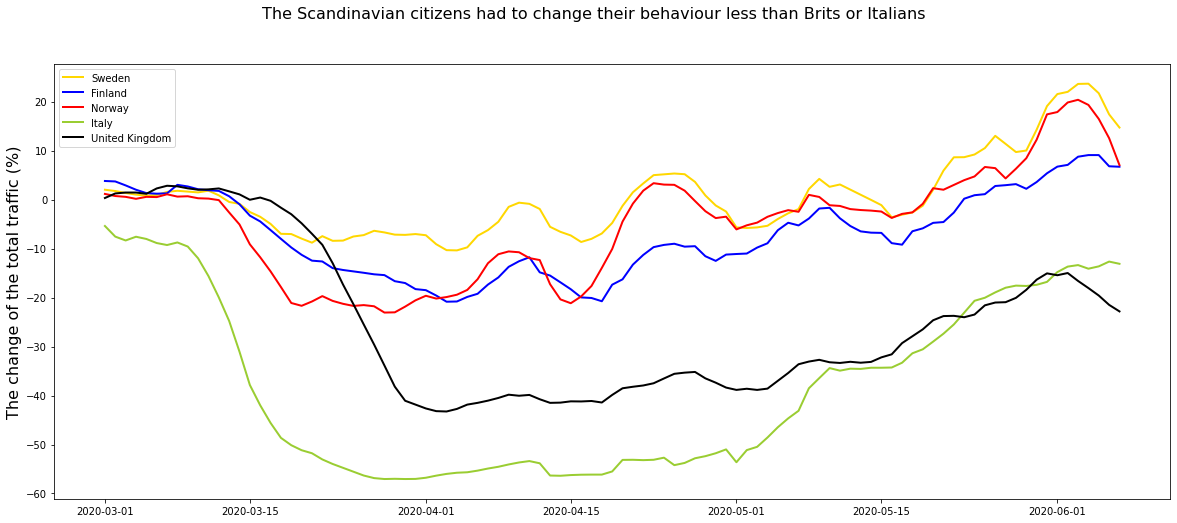

In [65]:
df1 = load_mobility_raw_onlynan()
plot_start_point = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
df1 = df1[df1['date'] >= plot_start_point ]

fig = plt.figure(figsize=(20,8))

# Scandinavian countries
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Sweden')], 
        marker='', color='gold', linewidth=2, label="Sweden")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Finland')],
         marker='', color='blue', linewidth=2, label="Finland")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Norway')],
         marker='', color='red', linewidth=2, label="Norway")

# In comparision Austria, Italy
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Italy')],
         marker='', color='yellowgreen', linewidth=2, label="Italy")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'United Kingdom')],
         marker='', color='black', linewidth=2, label="United Kingdom")

plt.ylabel('The change of the total traffic (%)', fontsize=16)
fig.suptitle('The Scandinavian citizens had to change their behaviour less than Brits or Italians', fontsize=16)
plt.legend(loc="upper left")

## The traffic was essential to get down in countries where COVID-19 escalated. However, there are countries who can deal with COVID-19 only getting the traffic down a little bit!

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


Text(0.5, 0, 'Average change in traffic, during 60 days after the first COVID-19 death (%)')

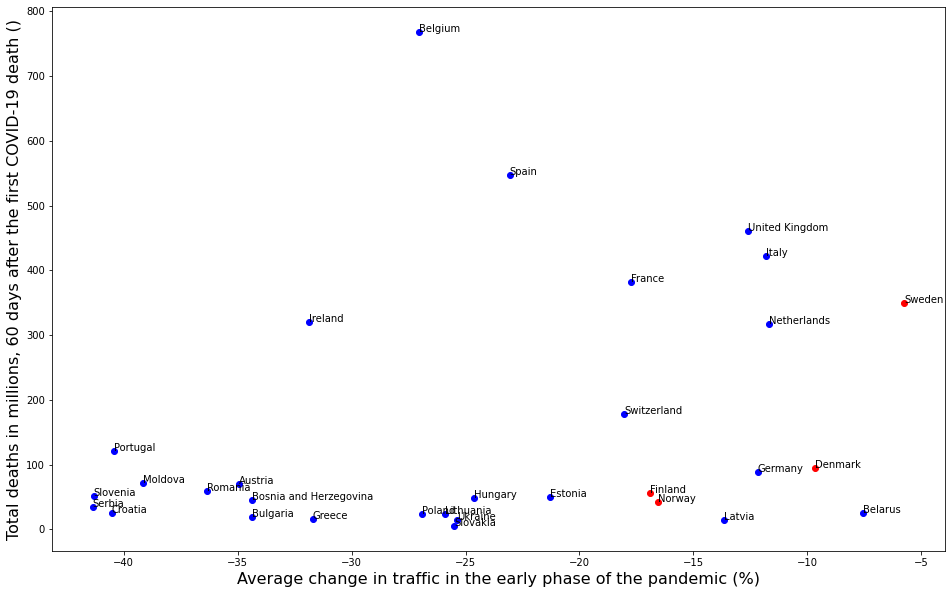

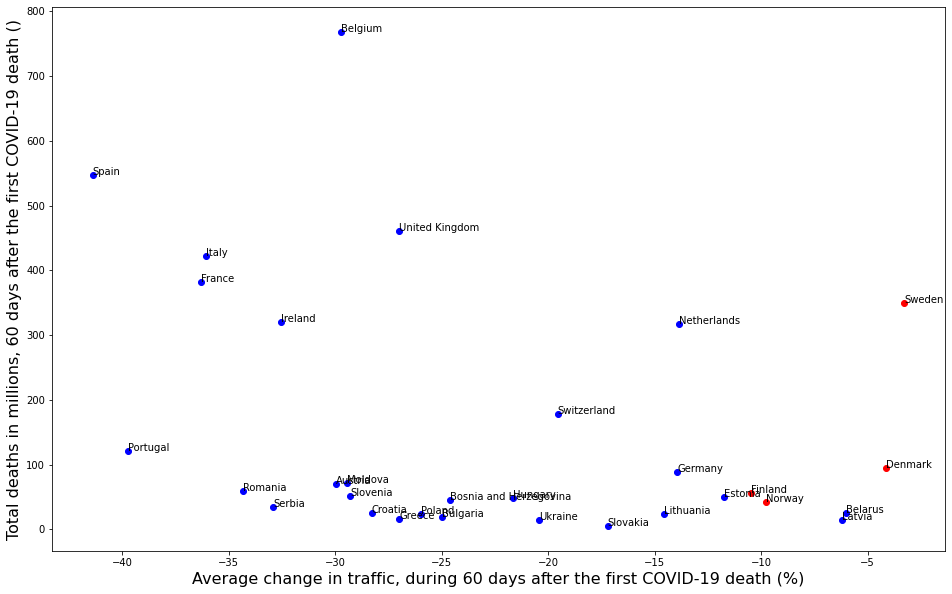

In [66]:
df2 = load_mobility_raw_onlynan()


total_deaths_per_million_last = []

for i in range(len(european_countries)):
    total_deaths_per_million_last.append(total_deaths_per_million[i][-1])

    
means_traffic_beginning = []

for i in range(len(european_countries)):
    current_country = european_countries[i]
    period_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    period_end_point = date_death_limit[i] + datetime.timedelta(days=short_interval_end)
    
    means_traffic_beginning.append(
        df2.loc[(df2['country_region'] == current_country) &
                (df2['date'] >= period_start_point) & (df2['date'] <= period_end_point)
               ]['Total Mobility'].mean())

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(means_traffic_beginning[0:nordic_countries], 
           total_deaths_per_million_last[0:nordic_countries], color='red')
    
ax.scatter(means_traffic_beginning[nordic_countries:num_countries],
           total_deaths_per_million_last[nordic_countries:num_countries],
           color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (means_traffic_beginning[i], total_deaths_per_million_last[i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic in the early phase of the pandemic (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 30 days

#################################################################################################

means_traffic_end = []

for i in range(len(european_countries)):
    current_country = european_countries[i]
    period_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    period_end_point = date_death_limit[i] + datetime.timedelta(days=interval_end)
    
    means_traffic_end.append(
        df2.loc[(df2['country_region'] == current_country) &
                (df2['date'] >= period_start_point) & (df2['date'] <= period_end_point)
               ]['Total Mobility'].mean())

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(means_traffic_end[0:nordic_countries], 
           total_deaths_per_million_last[0:nordic_countries], color='red')
    
ax.scatter(means_traffic_end[nordic_countries:num_countries],
           total_deaths_per_million_last[nordic_countries:num_countries],
           color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (means_traffic_end[i], total_deaths_per_million_last[i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic, during 60 days after the first COVID-19 death (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 30 days

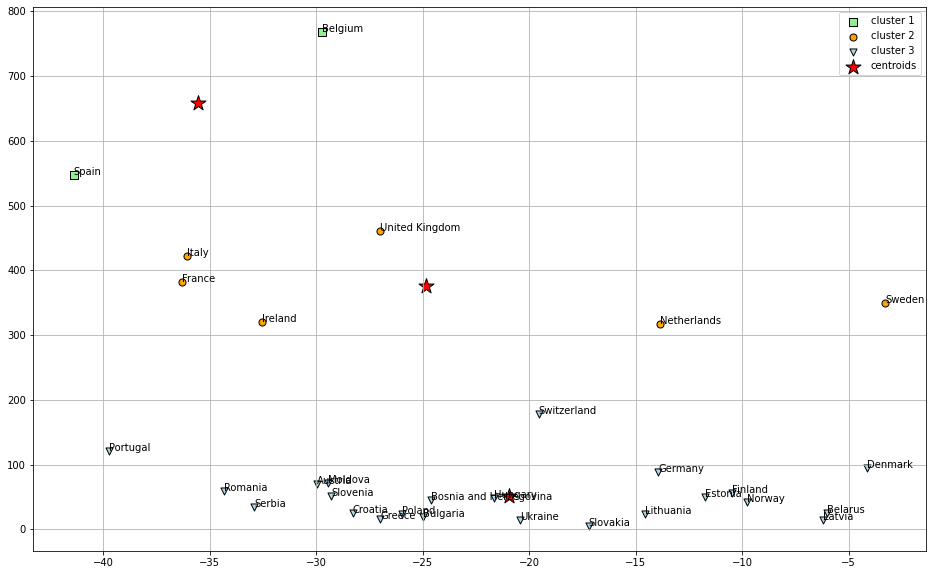

In [138]:
X = np.stack((np.array(means_traffic_end), np.array(total_deaths_per_million_last)), axis=1)

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

fig, ax = plt.subplots(figsize=(16, 10))

# plot the 3 clusters
ax.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

ax.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

ax.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)


# plot the centroids
ax.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (means_traffic_end[i], total_deaths_per_million_last[i]))
    
plt.legend(scatterpoints=1)
plt.grid()
plt.show()


## Plot the rate of NPIs, the change in traffic data, the change in infected data and deaths

Without any changes in NPIs, people changed their behaviour in a way which strongly correlates with the newly reported infected and deaths


/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


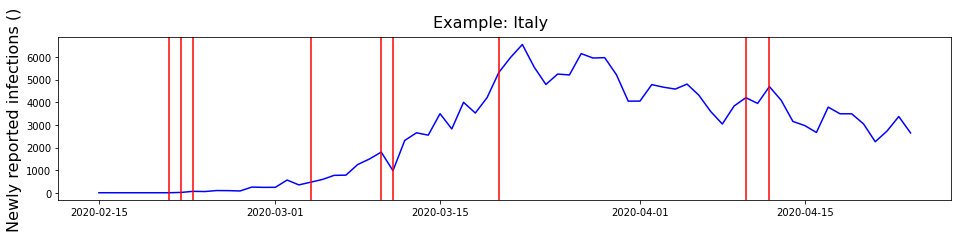

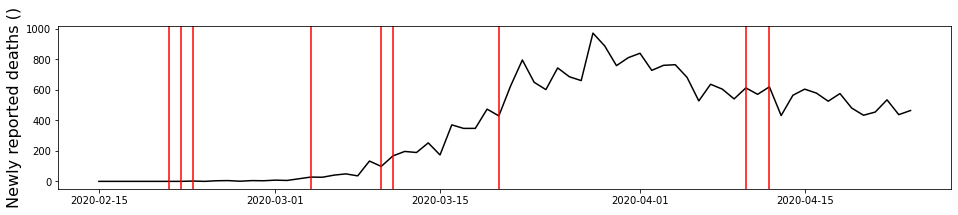

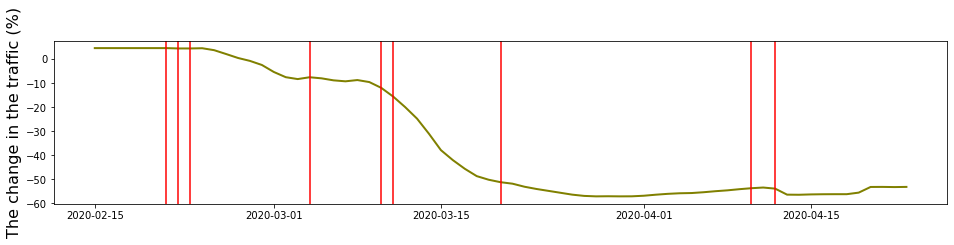

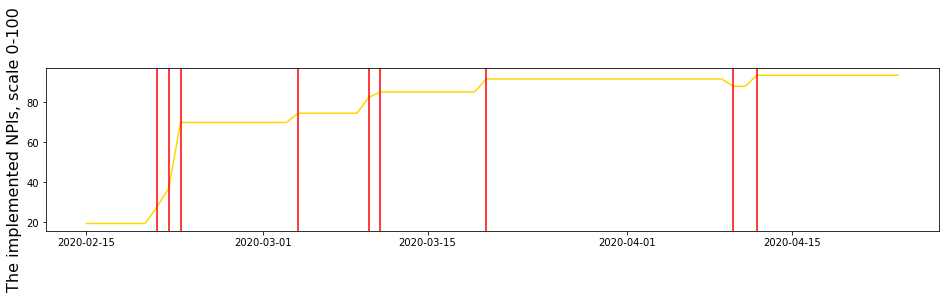

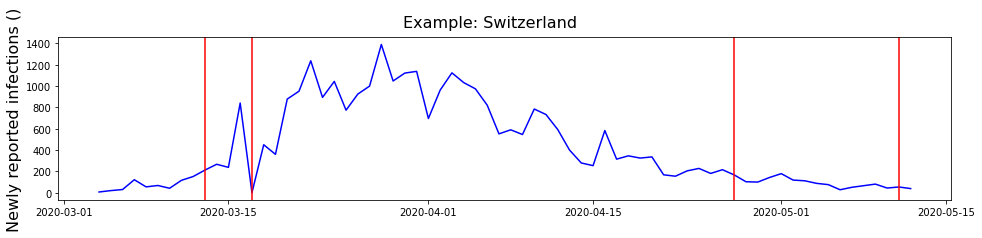

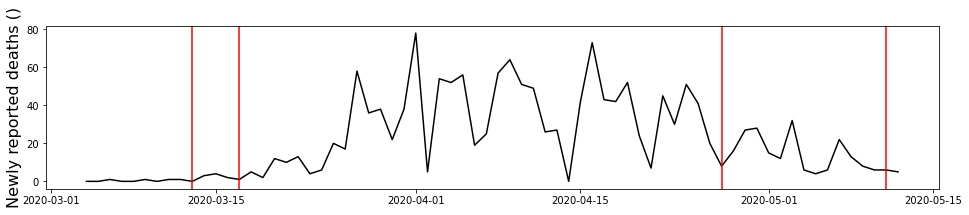

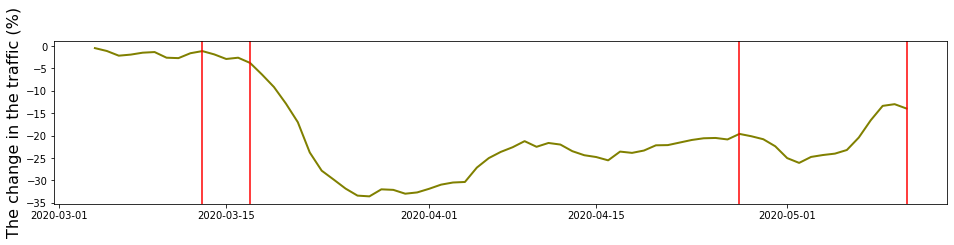

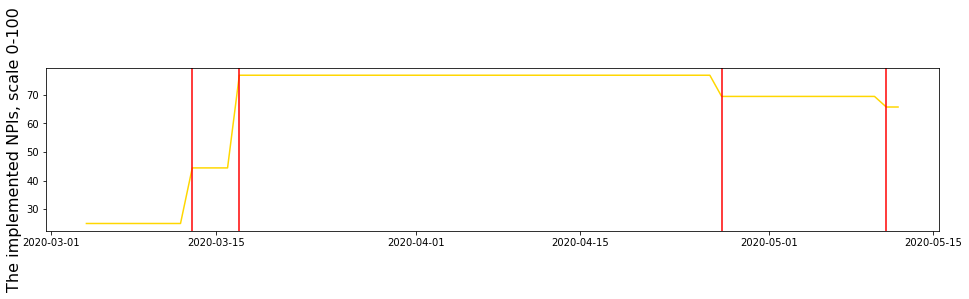

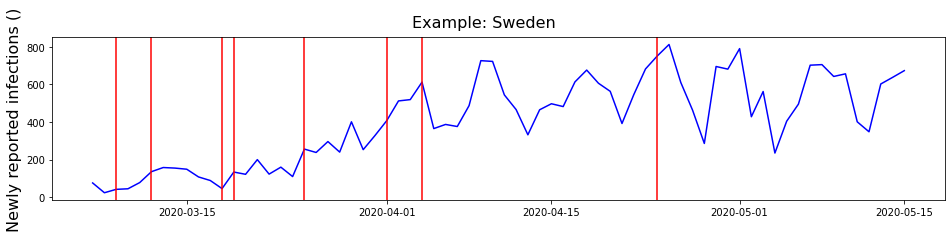

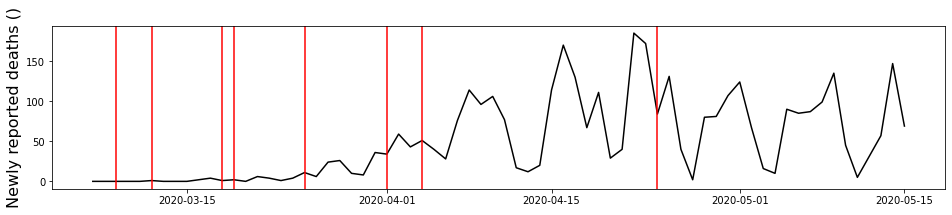

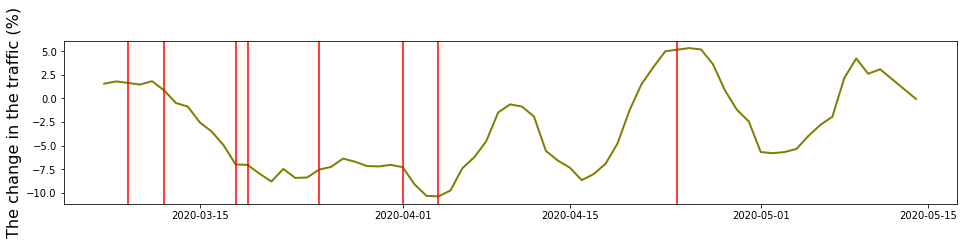

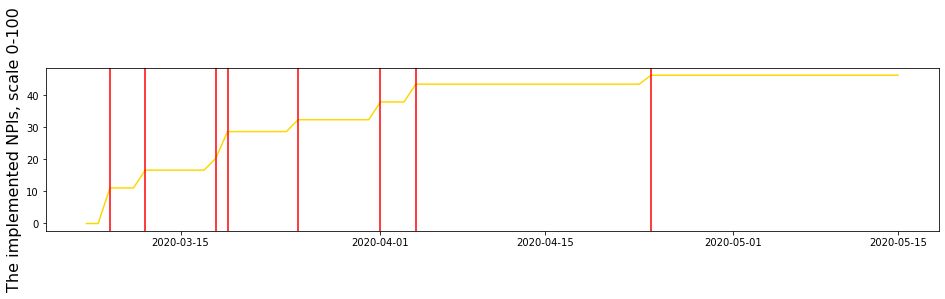

In [67]:
plotted_countries = [7, 19, 0]

print("Without any changes in NPIs, people changed their behaviour in a way which strongly correlates with the newly reported infected and deaths")

for i in plotted_countries:
    current_country = european_countries[i]
    plot_start_date = date_death_limit[i] - timedelta(days=interval_start)  
    dates = [plot_start_date + datetime.timedelta(days=x) for x in range(len_interval)] # tämä oikein

    fig, ax = plt.subplots(figsize=(16, 3))

    ax.plot(dates, new_infections[i], color='blue')
    plt.ylabel('Newly reported infections ()', fontsize=16)

    fig.suptitle(
        " ".join(("Example:", european_countries[i])),
        fontsize=16)

    for j in range(len(npi_change_dates[i])):
        plt.axvline(npi_change_dates[i][j], color='r')

    #ax.plot(dates, change_new_infections[i], color='blue')
    #plt.ylabel('The change in the infections ()', fontsize=16)

    #ax.plot(dates, change_new_deaths[i], color='black')
    #plt.ylabel('The change in the deaths ()', fontsize=16)

    ##################################################################################

    fig1, ax1 = plt.subplots(figsize=(16, 3))

    ax1.plot(dates, new_deaths[i], color='black')
    plt.ylabel('Newly reported deaths ()', fontsize=16)

    for j in range(len(npi_change_dates[i])):
        plt.axvline(npi_change_dates[i][j], color='r')

    ##################################################################################

    fig2, ax2 = plt.subplots(figsize=(16, 3))

    df3 = load_mobility_raw_onlynan()
    df3 = df3[(df3['date'] >= plot_start_date) & (df3['date'] < dates[-1])
              & (df3['country_region'] == current_country)]

    ax2.plot( 'date', 'Smooth Mobility', data=df3.loc[(df3['country_region'] == current_country)], 
            marker='', color='olive', linewidth=2)

    plt.ylabel('The change in the traffic (%)', fontsize=16)

    for j in range(len(npi_change_dates[i])):
        plt.axvline(npi_change_dates[i][j], color='r')

    ##################################################################################

    fig3, ax3 = plt.subplots(figsize=(16, 3))

    ax3.plot(dates, npi_developments[i], color='gold')

    plt.ylabel('The implemented NPIs, scale 0-100', fontsize=16)

    for j in range(len(npi_change_dates[i])):
        plt.axvline(npi_change_dates[i][j], color='r')
